In [1]:
## anaconda3 (Python 3.9.13) Kernel

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# pair trade packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

# Load Pairs Data


In [2]:
def custom_date_parser(date_str):
    return datetime.strptime(date_str, '%d/%m/%Y')

# Load the dictionary from the pickle file
with open('pairsOutcome.pkl', 'rb') as file:
    pairsOutcome = pickle.load(file)

print("Dictionary loaded from pairsOutcome.pkl")


# Load stock data and get return 
tpxData = pd.read_csv('TPX_prices.csv', index_col=0, parse_dates=True, date_parser=custom_date_parser)
tpxData = tpxData.dropna(axis='columns')
return_df = (tpxData / tpxData.shift(1)) - 1

Dictionary loaded from pairsOutcome.pkl


/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_4775/3199335484.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  tpxData = pd.read_csv('TPX_prices.csv', index_col=0, parse_dates=True, date_parser=custom_date_parser)


In [3]:
len(pairsOutcome)

17

# Get Pair Trade Portfolio
`pairsOutcome` already have TOPIX stocks with highest liquidity and are tested for stationarity over a 1 year window

Choose top 10 known pair trades by returns in the total dataset

In [4]:
import csv

with open("output_clustering.csv", 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    working_pairs = [tuple(row) for row in reader]


top_keys = [f"{pair[0]} {pair[1]}" for pair in working_pairs]

print("17 clustered pair trades:")
for i, key in enumerate(top_keys, 1):
    print(f"{i}. Key: {key}, Value: {pairsOutcome[key].cumpnl.iloc[-2]:.2f}")

17 clustered pair trades:
1. Key: 6503 JP Equity 7269 JP Equity, Value: 1.33
2. Key: 6326 JP Equity 6954 JP Equity, Value: 1.19
3. Key: 8053 JP Equity 8058 JP Equity, Value: 0.52
4. Key: 4901 JP Equity 9613 JP Equity, Value: 1.10
5. Key: 6988 JP Equity 7267 JP Equity, Value: 0.65
6. Key: 4901 JP Equity 6702 JP Equity, Value: -0.34
7. Key: 4684 JP Equity 7832 JP Equity, Value: 0.89
8. Key: 7267 JP Equity 8306 JP Equity, Value: 1.16
9. Key: 7267 JP Equity 8801 JP Equity, Value: 0.64
10. Key: 4519 JP Equity 7532 JP Equity, Value: 1.14


## Calculate baseline Pair Trade Portfolio Returns

Assume that each pair  and there is no diversification of returns. Each Pair Trade is self-funded and only has risk of 10% of initial investment (1 unit).

2013 is used as warm up year to consolidate rolling window aggregate mid and Std dev data. Investment only starts from 2014.

In [5]:
dailypnl_data = [pairsOutcome[key]['dailypnl'] for key in top_keys]

df_daily_returns =  pd.DataFrame(dailypnl_data).T # Transpose to align rows
df_daily_returns.cumsum()

,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl
Date,,,,,,,,,,
1/1/2013,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2/1/2013,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3/1/2013,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4/1/2013,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
7/1/2013,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...
27/5/2024,1.308067,1.19382,0.518366,1.083350,0.645342,-0.338771,0.886695,1.173548,0.644275,1.13833
28/5/2024,1.343141,1.19382,0.518366,1.086770,0.645342,-0.338771,0.886695,1.162874,0.644275,1.13833
29/5/2024,1.371096,1.19382,0.518366,1.090710,0.645342,-0.338771,0.886695,1.162874,0.644275,1.13833


In [6]:
ten_portf_return = np.exp(df_daily_returns.cumsum().iloc[-2]).sum()/10
f"From 1 Jan 2014 investing 1 unit resulted in 31 May 2024 return {ten_portf_return:.2f} unit"

'From 1 Jan 2014 investing 1 unit resulted in 31 May 2024 return 2.51 unit'

In [7]:
f"Baseline Annual return is {(np.log(ten_portf_return))/10.5*100:.2f}%"

'Baseline Annual return is 8.75%'

### Train Results

In [8]:
baseline_train_mean_return = df_daily_returns.iloc[:2868].cumsum().mean(axis=1)[-1]
f"Baseline Train Mean return is {baseline_train_mean_return:.5f}"

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_4775/422782263.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  baseline_train_mean_return = df_daily_returns.iloc[:2868].cumsum().mean(axis=1)[-1]


'Baseline Train Mean return is 0.74129'

### Test Results

In [9]:
baseline_test_mean_return = df_daily_returns.iloc[2869:].cumsum().iloc[-2].mean()
f"Baseline Test Mean return is {baseline_test_mean_return:.5f}"

'Baseline Test Mean return is 0.08739'

## Baseline graph

Investing starts from 2014 as a warm start for 1 year rolling window (from 2013) we plot the total returns.

In [10]:
df_port_return = df_daily_returns.cumsum().sum(axis=1)/10
np.exp(df_port_return).describe()

count    2979.000000
mean        1.288108
std         0.348571
min         0.918642
25%         1.006095
50%         1.146149
75%         1.498417
max         2.296241
dtype: float64

Text(0.5, 1.0, 'Baseline returns')

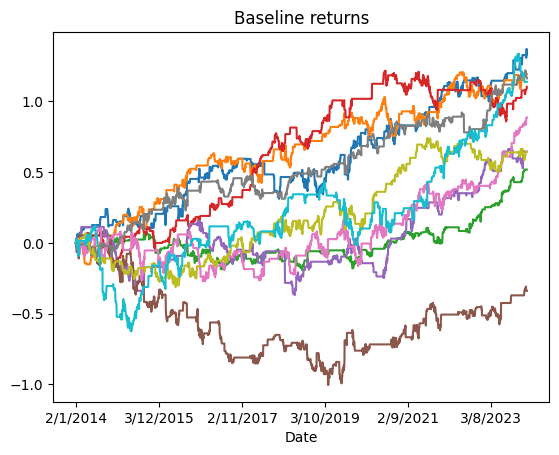

In [11]:
df_daily_returns.cumsum()[262:-1].plot(legend=None)
plt.title("Baseline returns")

In [12]:
postion_data = [pairsOutcome[key]['position'] for key in top_keys]

pd.DataFrame(postion_data).T.abs().sum(axis=1).describe()

count    2979.000000
mean        3.422625
std         1.826316
min         0.000000
25%         2.000000
50%         4.000000
75%         5.000000
max         9.000000
dtype: float64

# Machine Learning Challenge

## Background
Initial evaluation of the baseline portfolio shows that draw downs are small. Originally team had the idea of using Machine Learning to optimise for sizing of these pair trades. However since there was no significant drawdowns the returns are linearly increasing with investment sizing i.e. greater nominal investment in the the pair trade the proportionate increase in returns without realising significant drawdown risk.

Instead of optimising for sizing, we can explore Machine Learning in terms of strategy on this stationary dataset. Whereas our prescribed strategy is to enter at +/- 1 std dev, exit at 0 with +/- 2 std dev stop loss. These are only suggestions and arbitrary levels.

With Machine Learning, we can discover if it will uncover the mean reverting nature and recommend another threshhold. We use Q Learner to understand state space with the same spread, mid, std dev parameters as the baseline.

### Steps
#### Environment:
- State Space: A set of all possible states the agent can be in.  
  - [spread, mid, 2 sd low, 1 sd low, 1 sd high, 2 sd high]
- Action Space: A set of all possible actions the agent can take in each state.   
  - [-1, # short\
      0, # uninvested\
      1  # long]   
- Reward Function: A function that assigns a numerical reward to each state-action pair, indicating the immediate consequence of taking a particular action in a specific state.
  - dailypnl
- Transition Function: A function that determines the probability of transitioning from one state to another when a particular action is taken.
  - deterministic based on historical performance
#### Agent:

- Q-Table: A matrix that stores the estimated Q-values for each state-action pair. Q-values represent the expected future reward for taking a specific action in a given state.   
  - continuous Q table?
- Learning Rate (α): A parameter that controls how much the Q-values are updated with each new experience.   
- Discount Factor (γ): A parameter that determines the importance of future rewards. A higher discount factor gives more weight to future rewards.   
- Exploration Rate (ε): A parameter that controls the balance between exploration (trying new actions) and exploitation (choosing the action with the highest Q-value).   
- Q-Learning Algorithm:

  - Initialization: Initialize the Q-table with random values or zeros.   
  - Exploration and Exploitation: Use an exploration strategy (e.g., ε-greedy) to choose an action:
    - With probability ε, choose a random action.   
    - With probability 1-ε, choose the action with the highest Q-value for the current state.   
  
  - Take Action: Execute the chosen action in the environment.   
  - Observe Reward and Next State: Observe the immediate reward and the next state resulting from the action.
- Update Q-Value: Update the Q-value of the current state-action pair using the following formula:

#### Training and Test set

2013 is used for warm start\
2014 - 2023 train data since NN need a lot of training data\
2024 onwards (5 months) test data


In [17]:
## Get pair stock data
def custom_date_parser(date_str):
    return datetime.strptime(date_str, '%d/%m/%Y')
valid = pd.read_csv('validPairs5.csv', 
                    index_col=0, 
                    parse_dates=True, 
                    date_parser=custom_date_parser)
## get list of pair stocks
validPairsList = [
    [item.strip() + ' Equity' for item in pair.split('Equity') if item.strip()]
    for pair in top_keys
]

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_4775/2263820838.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  valid = pd.read_csv('validPairs5.csv',


In [18]:
rollingWindow = 262
cutLossSd = 2

In [19]:
for pair in validPairsList:
    df = pd.DataFrame()

    #Calculate Standard Deviations
    df['spread'] = valid[f'spread_{pair[0]}_{pair[1]}']
    df['mid'] =  df['spread'].rolling(rollingWindow).mean()
    df['1sd high'] = df['spread'].rolling(rollingWindow).mean() + df['spread'].rolling(rollingWindow).std()
    df['1sd low'] = df['spread'].rolling(rollingWindow).mean() - df['spread'].rolling(rollingWindow).std()
    df['2sd high'] = df['spread'].rolling(rollingWindow).mean() + df['spread'].rolling(rollingWindow).std() * cutLossSd
    df['2sd low'] = df['spread'].rolling(rollingWindow).mean() - df['spread'].rolling(rollingWindow).std() * cutLossSd
    df['position'] = 0

    df.loc[(df['spread'] > df['1sd high']) & (df['spread'] < df['2sd high']), 'position'] = -1
    df.loc[(df['spread']< df['1sd low']) & (df['spread'] > df['2sd low']), 'position'] = 1

    #Calculate PnL
    df[f'{pair[0]} position'] = df['position']
    df[f'{pair[1]} position'] = df['position'] * -1
    df['dailypnl'] = df[f'{pair[1]} position']*return_df[f'{pair[1]}'].shift(-1) + df[f'{pair[0]} position']*return_df[f'{pair[0]}'].shift(-1)
    df['cumpnl'] = df['dailypnl'].cumsum()

    pairsOutcome[f'{pair[0]} {pair[1]}'] = df

In [20]:
-1*return_df[f'{pair[0]}'].iloc[1000+1] + 1*return_df[f'{pair[1]}'].iloc[1000+1]

-0.0036522408824405383

In [21]:
return_df[f'{pair[0]}'].iloc[1000+1], return_df[f'{pair[0]}'].shift(-1).iloc[1000]

(-0.018706896551724195, -0.018706896551724195)

In [22]:
return_df[f'{pair[0]}'].iloc[999:1002]

Date
2016-10-31   -0.004173
2016-11-01   -0.027906
2016-11-02   -0.018707
Name: 4519 JP Equity, dtype: float64

In [23]:
validPairsList

[['6503 JP Equity', '7269 JP Equity'],
 ['6326 JP Equity', '6954 JP Equity'],
 ['8053 JP Equity', '8058 JP Equity'],
 ['4901 JP Equity', '9613 JP Equity'],
 ['6988 JP Equity', '7267 JP Equity'],
 ['4901 JP Equity', '6702 JP Equity'],
 ['4684 JP Equity', '7832 JP Equity'],
 ['7267 JP Equity', '8306 JP Equity'],
 ['7267 JP Equity', '8801 JP Equity'],
 ['4519 JP Equity', '7532 JP Equity']]

In [24]:
dailypnl_data = [pairsOutcome[key]['dailypnl'] for key in top_keys]

df_daily_returns =  pd.DataFrame(dailypnl_data).T # Transpose to align rows
df_daily_returns.cumsum()

,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl
Date,,,,,,,,,,
2013-01-01,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2013-01-02,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2013-01-03,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2013-01-04,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2013-01-07,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...
2024-05-27,1.308067,1.19382,0.518366,1.083350,0.645342,-0.338771,0.886695,1.173548,0.644275,1.13833
2024-05-28,1.343141,1.19382,0.518366,1.086770,0.645342,-0.338771,0.886695,1.162874,0.644275,1.13833
2024-05-29,1.371096,1.19382,0.518366,1.090710,0.645342,-0.338771,0.886695,1.162874,0.644275,1.13833
